In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


In this notebook, we compute the maximal (resp. minimal) volume ellispoids and polynomial sublevel sets contained (containing) the square with vertices $(\pm 1, \pm 1)$. We start by defining the square with [Polyhedra](https://github.com/JuliaPolyhedra/Polyhedra.jl).

In [2]:
using Polyhedra
h = HalfSpace([1, 0], 1.0) ∩ HalfSpace([-1, 0], 1) ∩ HalfSpace([0, 1], 1) ∩ HalfSpace([0, -1], 1)
p = polyhedron(h);

We need to pick an SDP solver, see [here](http://www.juliaopt.org/JuMP.jl/dev/installation/#Getting-Solvers-1) for a list of available ones. Run one of the following two cells to choose choose the solver.

In [ ]:
using SCS
using SetProg
factory = with_optimizer(SCS.Optimizer, verbose=0);

In [ ]:
using CSDP    # CSDP is less appropriate than SCS and Mosek because it does not natively support
using SetProg # SOC constraints so they need to be bridged to SDP constraints.
factory = with_optimizer(CSDP.Optimizer, printlevel=0); # SOC constraints are needed for the nth_root

In [3]:
using MosekTools
using SetProg
factory = with_optimizer(Mosek.Optimizer, QUIET=true);

In [4]:
using LinearAlgebra
function support_function(set::SetProg.Sets.AbstractSet, direction)
    model = Model(factory)
    @variable(model, x[1:SetProg.Sets.dimension(set)])
    @constraint(model, x in set)
    @objective(model, Max, dot(direction, x))
    JuMP.optimize!(model)
    return JuMP.objective_value(model)
end

support_function (generic function with 1 method)

## John ellipsoid

The maximal volume ellispoid contained in a convex body is called its John ellipsoid.
The John ellipsoid for our square can be computed as follows.

In [5]:
model = Model(factory);
@variable(model, john, Ellipsoid(symmetric=true, dimension = 2))
cref = @constraint(model, john ⊆ p)
@objective(model, Max, nth_root(volume(john)))
@time JuMP.optimize!(model)
@show JuMP.termination_status(model)
@show JuMP.objective_value(model);

 18.743919 seconds (67.59 M allocations: 3.452 GiB, 8.72% gc time)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 1.0000000054702731


In [6]:
support_function(JuMP.value(john), [1, 1])

1.414213550721004

## Löwner ellipsoid

The minimal volume ellispoid contained in a convex body is called its Löwner ellipsoid.
The Löwner ellipsoid for our square can be computed as follows.

In [7]:
model = Model(factory);
@variable(model, löwner, Ellipsoid(symmetric=true, dimension = 2))
cref = @constraint(model, p ⊆ löwner)
@objective(model, Min, nth_root(volume(löwner)))
@time JuMP.optimize!(model)
@show JuMP.termination_status(model)
@show JuMP.objective_value(model);

  9.349817 seconds (58.19 M allocations: 3.028 GiB, 11.67% gc time)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 0.5000000005820153


In [8]:
support_function(JuMP.value(löwner), [1, 1])

2.0000000001323457

We can visualize the Löwner and John ellispoids as follows.

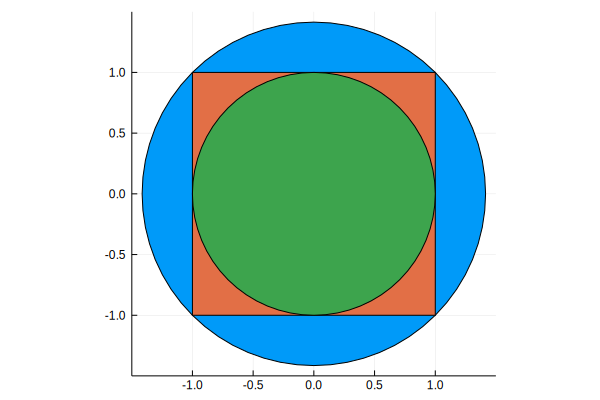

In [9]:
using Plots
plot(ratio=:equal)
plot!(JuMP.value(löwner))
plot!(p)
plot!(JuMP.value(john))

## Higher degree polynomials

Ellispoids are the sublevel sets of positive definite *quadratic* forms.
To allow for more sophisticated shapes, we could instead look for sublevel sets of *quartic* forms.
For this, we simply need to replace `Ellipsoid(dimension=2)` by `PolySet(degree=4, dimension=2)`.
Note that the volumes optimized are not exactly the volume anymore but provide a reasonable heuristic.

### Maximal volume quartic sublevel set contained in the square

In [10]:
model = Model(factory);
@variable(model, quartic_inner, PolySet(degree = 4, symmetric = true, convex = true))
cref = @constraint(model, quartic_inner ⊆ p)
@objective(model, Max, nth_root(volume(quartic_inner)))
@time JuMP.optimize!(model)
@show JuMP.termination_status(model)
@show JuMP.objective_value(model);

  8.738291 seconds (22.19 M allocations: 1.088 GiB, 7.89% gc time)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 6.447419338712412


In [11]:
support_function(JuMP.value(quartic_inner), [1, 1])

1.4823584095346904

In [12]:
model = Model(factory);
@variable(model, quartic_inner, PolySet(degree = 4, symmetric = true, convex = true, point=SetProg.InteriorPoint([0.0, 0.0])))
cref = @constraint(model, quartic_inner ⊆ p)
@objective(model, Max, L1_heuristic(volume(quartic_inner), [1.0, 1.0]))
@time JuMP.optimize!(model)
@show JuMP.termination_status(model)
@show JuMP.objective_value(model);

  0.275821 seconds (628.05 k allocations: 31.005 MiB, 21.85% gc time)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 4.26666666260044


### Minimal volume quartic sublevel set containing the square

In [13]:
model = Model(factory);
@variable(model, quartic_outer, PolySet(symmetric=true, degree = 4, convex=true))
cref = @constraint(model, p ⊆ quartic_outer)
@objective(model, Min, nth_root(volume(quartic_outer)))
@time JuMP.optimize!(model)
@show JuMP.termination_status(model)
@show JuMP.objective_value(model);

  0.121602 seconds (203.87 k allocations: 10.495 MiB)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 1.6118548821006446


In [14]:
support_function(JuMP.value(quartic_outer), [1, 1])

1.999999986579064

We can visualize the quartic sublevel sets as follows.

In [15]:
SetProg.polynomial(JuMP.value(quartic_inner).p)

ErrorException: type Polar has no field p

In [16]:
SetProg.polynomial(JuMP.value(quartic_outer).p)

0.30177297950529897x₁⁴ + 1.6546876107131807e-15x₁³x₂ + 0.3964499829468738x₁²x₂² + 2.8451657465113703e-15x₁x₂³ + 0.30177703542516215x₂⁴

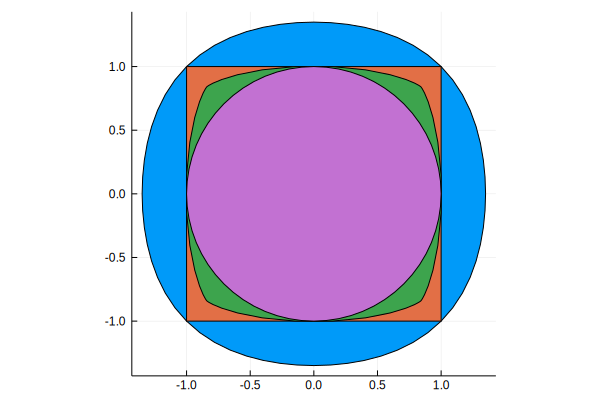

In [17]:
using Plots
plot(ratio=:equal)
plot!(JuMP.value(quartic_outer))
plot!(p)
plot!(JuMP.value(quartic_inner))
plot!(JuMP.value(john))

In [18]:
function inner_L1(d)
    model = Model(factory);
    @variable(model, quartic_innerL1, PolySet(symmetric=true, degree = d, convex=true))
    cref = @constraint(model, quartic_innerL1 ⊆ p)
    @objective(model, Max, L1_heuristic(volume(quartic_innerL1), [1.0, 1.0]))
    @time JuMP.optimize!(model)
    @show JuMP.termination_status(model)
    @show JuMP.objective_value(model)
    return JuMP.value(quartic_innerL1)
end

inner_L1 (generic function with 1 method)

In [19]:
S2 = inner_L1(2)
S4 = inner_L1(4)
S6 = inner_L1(6)
S8 = inner_L1(8)
S10 = inner_L1(10)

  0.068831 seconds (128.71 k allocations: 6.346 MiB)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 2.6666666666379877
  0.003476 seconds (4.55 k allocations: 301.625 KiB)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 4.26666666260044
  0.005859 seconds (6.26 k allocations: 424.422 KiB)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 9.142854202672021
  0.006286 seconds (8.26 k allocations: 586.203 KiB)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 23.25747428514344
  0.007432 seconds (10.48 k allocations: 752.375 KiB)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 62.92672034900617


SetProg.Sets.Polar{Float64,SetProg.Sets.ConvexPolynomialSublevelSetAtOrigin{Float64}}(SetProg.Sets.ConvexPolynomialSublevelSetAtOrigin{Float64}(10, SumOfSquares.GramMatrix{Float64,DynamicPolynomials.Monomial{true},DynamicPolynomials.MonomialVector{true}}([1.0 -5.04442e-15 … 1.17149 -3.27804e-16; -5.04442e-15 61.8282 … -1.81717e-14 1.17149; … ; 1.17149 -1.81717e-14 … 61.8282 -5.30646e-15; -3.27804e-16 1.17149 … -5.30646e-15 1.0], DynamicPolynomials.Monomial{true}[x₁⁵, x₁⁴x₂, x₁³x₂², x₁²x₂³, x₁x₂⁴, x₂⁵]), [90.0 -6.10145e-14 … 51.5282 -8.99162e-13; -6.10145e-14 92.4539 … -5.15415e-12 51.5282; … ; 51.5282 -5.15415e-12 … 92.4539 -8.25066e-14; -8.99162e-13 51.5282 … -8.25066e-14 90.0]))

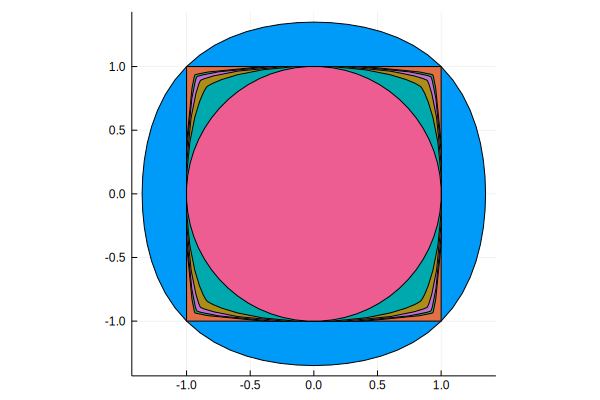

In [20]:
using Plots
plot(ratio=:equal)
plot!(JuMP.value(quartic_outer))
plot!(p)
plot!(S10)
plot!(S8)
plot!(S6)
plot!(S4)
plot!(S2)

## Non-homogeneous

In [21]:
using Polyhedra
shift = 1.1
h = HalfSpace([1, 0], 1.0 + shift) ∩ HalfSpace([-1, 0], 1.0 - shift) ∩ HalfSpace([0, 1], 1) ∩ HalfSpace([0, -1], 1)
p = polyhedron(h);

In [22]:
model = Model(factory);
@variable(model, john, Ellipsoid(point=SetProg.InteriorPoint([shift, 0.0])))
cref = @constraint(model, john ⊆ p)
@objective(model, Max, nth_root(volume(john)))
@time JuMP.optimize!(model)
@show JuMP.termination_status(model)
@show JuMP.objective_value(model);

  2.719269 seconds (6.60 M allocations: 326.959 MiB, 7.15% gc time)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 0.30437683327156373


In [23]:
JuMP.value(john)

SetProg.Sets.PerspectiveDual{Float64,SetProg.Sets.Householder{Float64,SetProg.Sets.ShiftedEllipsoid{Float64},Float64}}(SetProg.Sets.Householder{Float64,SetProg.Sets.ShiftedEllipsoid{Float64},Float64}(SetProg.Sets.ShiftedEllipsoid{Float64}([0.204746 -1.48262e-6; -1.48262e-6 0.452489], [-0.225221, 1.61892e-6], -0.7522573495421817), -0.45248869371450345z² - 0.9954751304239675zx₁ + 1.6097143006322735e-8zx₂ - 0.09502264901434204x₁² - 4.390436041890046e-6x₁x₂ + 0.4524886951996058x₂², [1.1, 0.0], z, DynamicPolynomials.PolyVar{true}[x₁, x₂]))

In [24]:
support_function(JuMP.value(john), [1, 1])

2.5142100915471106

In [25]:
support_function(JuMP.value(john), [-1, 0])

-0.10000002531454462

In [26]:
support_function(JuMP.value(john), [1, 0])

2.099999984082508

In [27]:
support_function(JuMP.value(john), [0, 1])

0.9999999838536954

In [28]:
SetProg.Sets.ellipsoid(JuMP.value(john))

SetProg.Sets.Translation{SetProg.Sets.EllipsoidAtOrigin{Float64},Float64,Array{Float64,1}}(SetProg.Sets.EllipsoidAtOrigin{Float64}([1.0 4.871e-6; 4.871e-6 1.0]), [1.1, -1.77873e-8])

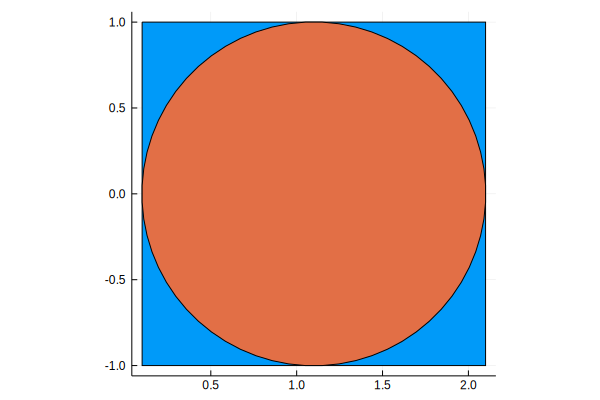

In [29]:
using Plots
plot(ratio=:equal)
plot!(p)
plot!(JuMP.value(john))

In [30]:
model = Model(factory);
@variable(model, quartic_inner, PolySet(convex=true, degree=2, point=SetProg.InteriorPoint([shift, 0.0])))
cref = @constraint(model, quartic_inner ⊆ p)
@objective(model, Max, L1_heuristic(volume(quartic_inner), [1.0, 1.0]))
@time JuMP.optimize!(model)
@show JuMP.termination_status(model)
@show JuMP.objective_value(model);

  1.043669 seconds (1.80 M allocations: 88.899 MiB, 4.20% gc time)
JuMP.termination_status(model) = OPTIMAL::TerminationStatusCode = 1
JuMP.objective_value(model) = 0.8763129974625536


In [31]:
v = JuMP.value(quartic_inner)
v.set.p

-0.45248868695057176z² - 0.9954752851170244zx₁ + 2.4562268239861748e-15zx₂ - 0.09502276221662484x₁² + 3.189124406449482e-12x₁x₂ + 0.45248871180645805x₂²

In [32]:
v = JuMP.value(quartic_inner)
v.set.p

-0.45248868695057176z² - 0.9954752851170244zx₁ + 2.4562268239861748e-15zx₂ - 0.09502276221662484x₁² + 3.189124406449482e-12x₁x₂ + 0.45248871180645805x₂²

In [33]:
support_function(JuMP.value(quartic_inner), [1, 1])

2.51421380476945

In [34]:
support_function(JuMP.value(quartic_inner), [1, 0])

2.100000246602012

In [35]:
support_function(JuMP.value(quartic_inner), [-1, 0])

-0.10000013304400399

In [36]:
support_function(JuMP.value(quartic_inner), [0, 1])

0.9999999989318874

In [37]:
support_function(JuMP.value(quartic_inner), -[0, 1])

0.9999999989318705

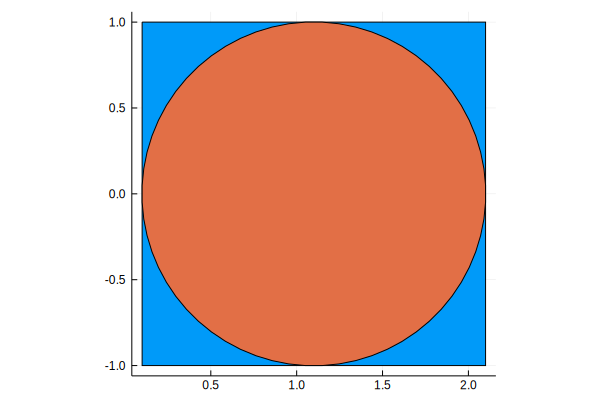

In [38]:
using Plots
plot(ratio=:equal)
plot!(p)
plot!(JuMP.value(quartic_inner))